In [90]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from scipy import signal
import matplotlib.pylab as pl
import time
import cv2 as cv
import ot

In [2]:
def costMatrixConvolution(b, nl, nc, F, eps, alpha):    
    # Construction du vecteur de distance sur l'axe des colonnes
    tc = np.linspace(0,1,nc)
    vect1 = np.array(list(reversed(tc)))
    vect2 = np.array(list(tc))
    vect2 = vect2[1:nc]
    G1 = np.exp(-vect1**2/eps)
    G2 = np.exp(-vect2**2/eps)
    G = np.concatenate((G1, G2))

    # Construction du vecteur de distance sur l'axe des lignes
    tl = np.linspace(0,1,nl)
    vect1 = np.array(list(reversed(tl)))
    vect2 = np.array(list(tl))
    vect2 = vect2[1:nl]
    V_p1 = np.exp(-vect1**2/eps)
    V_p2 = np.exp(-vect2**2/eps)
    V_p = np.concatenate((V_p1, V_p2))
    
    # Construction du vecteur de distance sur l'axe des couleurs
    tb = np.linspace(0,1,b)
    vect1 = np.array(list(reversed(tb)))
    vect2 = np.array(list(tb))
    vect2 = vect2[1:b]
    V1 = np.exp(-(alpha*vect1**2)/eps)
    V2 = np.exp(-(alpha*vect2**2)/eps)
    V = np.concatenate((V1, V2))
    
    
    #On init le vecteur R qui va contenir les convolutions K_i*F_i
    R = []
    #On commence à boucler sur le nombre de couleurs
    for i in range(b):
        #On extrait le vecteur Fi de F
        F_i = F[i*(nc*nl):(i+1)*(nc*nl)]
        #On init le vecteur R' qui va contenir les convolutions K_i_j*F_ij
        R_p = []
        
        #On boucle ensuite sur le nombre de lignes pour faire les opérations de convolutions
        for j in range(nl):
            #On extrait le vecteur Fi,j de F pour faire les convolutions dessus
            F_i_j = F_i[j*(nc):(j+1)*nc]
            #Convolution sur ce vecteur
            tmp = sc.signal.fftconvolve(G, F_i_j)
            Res = tmp[nc-1:2*nc - 1]
            R_p.append(Res)
            
        R_p = np.array(R_p) #Met en array pour pouvoir faire les calculs dessus -> On a ici le vecteur R'(0->nl-1)
                            #contenant les convolutions : les vecteurs R'(i) sont de taille nc pour 0<i<nl-1
        
        #On construit ici la convolution : V'*R'
        tmp = np.array(sc.signal.fftconvolve(V_p, R_p[:,0]))
        Qi = tmp[nl - 1:2*nl - 1]
        for k in range(nc-1):
            tmp = sc.signal.fftconvolve(V_p, R_p[:,k+1])
            Qi = np.block([[Qi], [tmp[nl - 1:2*nl - 1]]])

        Qi = np.transpose(Qi)
        A = Qi[0]
        for k in range(Qi.shape[0]-1):
            A = np.concatenate((A, Qi[k+1]), axis=None)
        
        R.append(A)

    R = np.array(R) #Met en array pour pouvoir faire les calculs dessus -> On a ici le vecteur R(0->b-1)
                       #contenant les convolutions : les vecteurs R(i) sont de taille nl pour 0<i<b-1

    #On construit ici la convolution : V*R qui est le résultat final K*F

    tmp = np.array(sc.signal.fftconvolve(V, R[:,0]))
    Q = tmp[b - 1:2*b - 1]
    for l in range((nl*nc)-1):
        tmp = sc.signal.fftconvolve(V, R[:,l+1])
        Q = np.block([[Q], [tmp[b - 1:2*b - 1]]])
    
    
    Q = np.transpose(Q)
    finalRes = Q[0]
    for k in range(Q.shape[0]-1):
            finalRes = np.concatenate((finalRes, Q[k+1]), axis=None)
    
    return finalRes


def im2vect(Img):
    b = Img.shape[2]
    nL = Img.shape[0]
    nC = Img.shape[1]
    vect = []
    for i in range(b):
        for j in range(nL):
            vect = np.concatenate((vect, Img[j,:,i].tolist()), axis=None)
    return vect    


def vect2Im(vect, shape):
    b = shape[2]
    nL = shape[0]
    nC = shape[1]
    image = []
    for k in range(nL):
        C = []
        for i in range(nC):
            B = []
            for j in range(b):
                  B = np.concatenate((B, vect[j*nC*nL + i + k*nC]), axis = None)
            C.append(B.tolist())
        image.append(C)
    image = np.array(image)
    return image

In [307]:
def convBarycenter(m, h, epsilon, alpha, Lambda, nbIter): #Fonction calcul de barycentre pour images de même taille
    nL = m.shape[0]
    nC = m.shape[1]
    b = m.shape[2]
    #v_m = np.ones(b*nL*nC)
    #v_h = np.ones(b*nL*nC)
    u_m = np.ones(b*nL*nC)
    u_h = np.ones(b*nL*nC)
    m_vect = im2vect(m)
    h_vect = im2vect(h)    
    for i in range(nbIter):
        v_m = m_vect/costMatrixConvolution(b, nL, nC, u_m, epsilon, alpha)
        v_h = h_vect/costMatrixConvolution(b, nL, nC, u_h, epsilon, alpha)
        convo_v_m = costMatrixConvolution(b, nL, nC, v_m, epsilon, alpha)
        convo_v_h = costMatrixConvolution(b, nL, nC, v_h, epsilon, alpha)
        f = np.exp(Lambda*np.log(u_m*convo_v_m) + (1-Lambda)*np.log(u_h*convo_v_h))
        
        u_m = f/convo_v_m
        u_h = f/convo_v_h
    
    res = vect2Im(f, m.shape)
    return res


def normalize(im):
    imNorm = np.zeros((im.shape))
    for i in range(im.shape[2]):
        if np.sum(im[:,:,i]) != 0:
            imNorm[:,:,i] = im[:,:,i]/np.sum(im[:,:,i])
        else:
            imNorm[:,:,i] = im[:,:,i]
    return imNorm

In [308]:
b = 3
nL = 8
nC = 8
m = np.ones((nL,nC,b))
h = np.ones((nL,nC,b))
for i in range(nL):
    for j in range(nC):
        if (i>=1 and i<=3) and (j>=1 and j<=3):
            m[i,j,0] = 0.5
            m[i,j,1] = 0
            m[i,j,2] = 0
        if (i>=4 and i<=6) and (j>=4 and j<=6):
            h[i,j,0] = 0.5
            h[i,j,1] = 0
            h[i,j,2] = 0

In [309]:
I1 = plt.imread('data/coucher.jpg')
I2 = plt.imread('data/ocean.jpg')
#m = I1[100:250, 450:650, :]/255
#h = I2[250:400,380:580,:]/255
#b = m.shape[2]
#nL = m.shape[0]
#nC = m.shape[1]

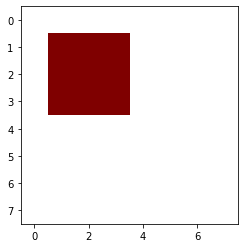

In [310]:
plt.imshow(m)

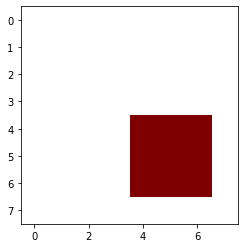

In [311]:
plt.imshow(h)

In [312]:
m = normalize(m)
h = normalize(h)

In [313]:
epsilon = 0.01
alpha = 5
Lambda = 0.5
nbIter = 3

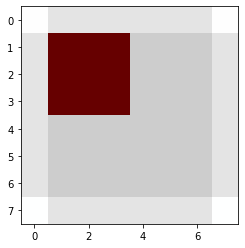

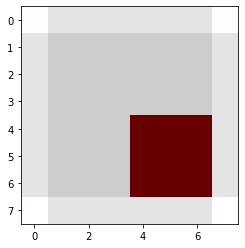

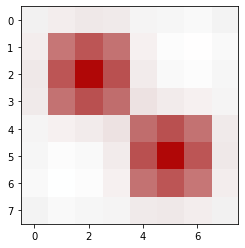

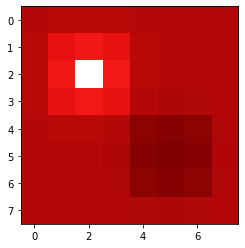

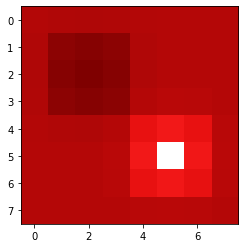

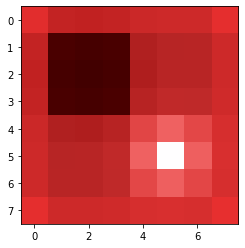

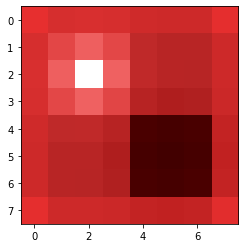

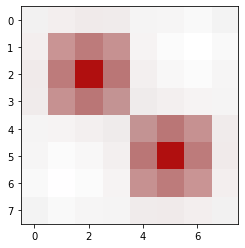

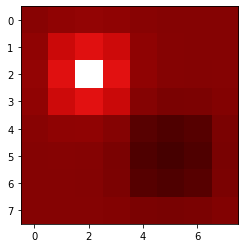

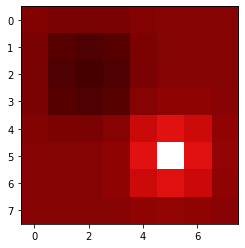

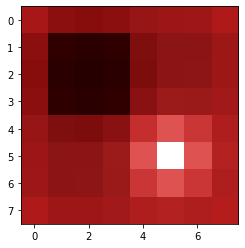

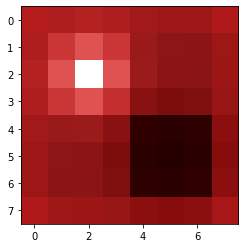

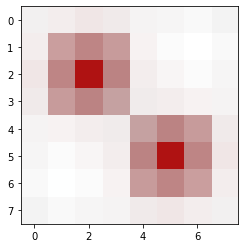

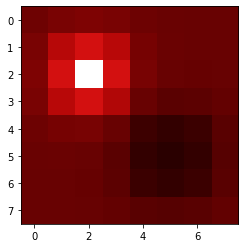

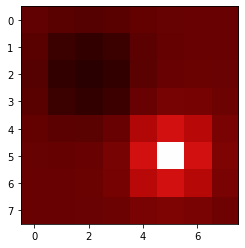

In [314]:
nL = m.shape[0]
nC = m.shape[1]
b = m.shape[2]
#v_m = np.ones(b*nL*nC)
#v_h = np.ones(b*nL*nC)
u_m = np.ones(b*nL*nC)
u_h = np.ones(b*nL*nC)
m_vect = im2vect(m)
h_vect = im2vect(h)    
for i in range(nbIter):
    v_m = m_vect/costMatrixConvolution(b, nL, nC, u_m, epsilon, alpha)
    recov_m = vect2Im(v_m, m.shape)
    recov_m_vis = np.zeros((recov_m.shape))
    recov_m_vis[:,:,0] = recov_m[:,:,0]*(1/recov_m[:,:,0].max())
    recov_m_vis[:,:,1] = recov_m[:,:,1]*(1/recov_m[:,:,1].max())
    recov_m_vis[:,:,2] = recov_m[:,:,2]*(1/recov_m[:,:,2].max())
    plt.figure()
    plt.imshow(recov_m_vis)
    #plt.imshow(recov_m)
    
    v_h = h_vect/costMatrixConvolution(b, nL, nC, u_h, epsilon, alpha)
    recov_h = vect2Im(v_h, m.shape)
    recov_h_vis = np.zeros((recov_h.shape))
    recov_h_vis[:,:,0] = recov_h[:,:,0]*(1/recov_h[:,:,0].max())
    recov_h_vis[:,:,1] = recov_h[:,:,1]*(1/recov_h[:,:,1].max())
    recov_h_vis[:,:,2] = recov_h[:,:,2]*(1/recov_h[:,:,2].max())
    plt.figure()
    plt.imshow(recov_h_vis)
    #plt.imshow(recov_h)

    convo_v_m = costMatrixConvolution(b, nL, nC, v_m, epsilon, alpha)
    convo_v_h = costMatrixConvolution(b, nL, nC, v_h, epsilon, alpha)
    f = np.exp(Lambda*np.log(u_m*convo_v_m) + (1-Lambda)*np.log(u_h*convo_v_h))
    #f = np.exp(Lambda*np.log(u_m*convo_v_m) + (1-Lambda)*np.log(u_h*convo_v_h))
    recov_f= vect2Im(f, m.shape)
    recov_f_vis = np.zeros((recov_f.shape))
    recov_f_vis[:,:,0] = recov_f[:,:,0]*(1/recov_f[:,:,0].max())
    recov_f_vis[:,:,1] = recov_f[:,:,1]*(1/recov_f[:,:,1].max())
    recov_f_vis[:,:,2] = recov_f[:,:,2]*(1/recov_f[:,:,2].max())
    plt.figure()
    plt.imshow(recov_f_vis)
    #plt.imshow(recov_f)

    u_m = f/convo_v_m
    u_m_recov = vect2Im(u_m, m.shape)
    recov_um_vis = np.zeros((u_m_recov.shape))
    recov_um_vis[:,:,0] = u_m_recov[:,:,0]*(1/u_m_recov[:,:,0].max())
    recov_um_vis[:,:,1] = u_m_recov[:,:,1]*(1/u_m_recov[:,:,1].max())
    recov_um_vis[:,:,2] = u_m_recov[:,:,2]*(1/u_m_recov[:,:,2].max())
    plt.figure()    
    plt.imshow(recov_um_vis)
    #plt.imshow(u_m_recov)
    
    u_h = f/convo_v_h
    u_h_recov = vect2Im(u_h, m.shape)
    recov_uh_vis = np.zeros((u_h_recov.shape))
    recov_uh_vis[:,:,0] = u_h_recov[:,:,0]*(1/u_h_recov[:,:,0].max())
    recov_uh_vis[:,:,1] = u_h_recov[:,:,1]*(1/u_h_recov[:,:,1].max())
    recov_uh_vis[:,:,2] = u_h_recov[:,:,2]*(1/u_h_recov[:,:,2].max())
    plt.figure()
    plt.imshow(recov_uh_vis)
    #plt.imshow(u_h_recov)
    
    
res = vect2Im(f, m.shape)


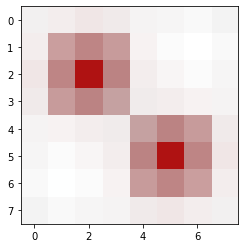

In [315]:
BCmod = np.zeros((res.shape))
BCmod[:,:,0] = res[:,:,0]*(1/res[:,:,0].max())
BCmod[:,:,1] = res[:,:,1]*(1/res[:,:,1].max())
BCmod[:,:,2] = res[:,:,2]*(1/res[:,:,2].max())

plt.imshow(BCmod)

# Avec normalisation

In [198]:
I1 = plt.imread('data/coucher.jpg')
I2 = plt.imread('data/ocean.jpg')
m = I1[100:250, 450:650, :]/255
h = I2[250:400,380:580,:]/255
b = m.shape[2]
nL = m.shape[0]
nC = m.shape[1]

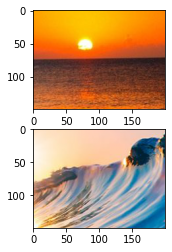

In [118]:
plt.subplot(2, 1, 1)
plt.imshow(m)
plt.subplot(2,1,2)
plt.imshow(h)

In [119]:
m_n = m/np.sum(m)
h_n = h/np.sum(h)

In [120]:
barycentre1 = convBarycenter(m, h, 0.01, 5, 0.5, 1)
barycentre2 = convBarycenter(m_n, h_n, 0.01, 5, 0.5, 1)

In [121]:
BCmod1 = np.zeros((barycentre1.shape))
BCmod1[:,:,0] = barycentre1[:,:,0]*(1/barycentre1[:,:,0].max())
BCmod1[:,:,1] = barycentre1[:,:,1]*(1/barycentre1[:,:,1].max())
BCmod1[:,:,2] = barycentre1[:,:,2]*(1/barycentre1[:,:,2].max())

In [122]:
BCmod2 = np.zeros((barycentre2.shape))
BCmod2[:,:,0] = barycentre2[:,:,0]*(1/barycentre2[:,:,0].max())
BCmod2[:,:,1] = barycentre2[:,:,1]*(1/barycentre2[:,:,1].max())
BCmod2[:,:,2] = barycentre2[:,:,2]*(1/barycentre2[:,:,2].max())

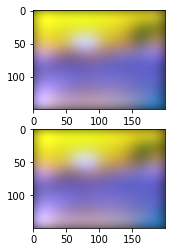

In [123]:
plt.subplot(2,1,1)
plt.imshow(BCmod1)
plt.subplot(2,1,2)
plt.imshow(BCmod2)

In [239]:
m_b = m[:,:,0:1]
h_b = h[:,:,0:1]

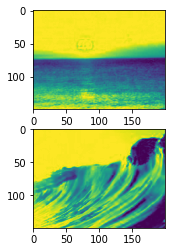

In [240]:
plt.subplot(2,1,1)
plt.imshow(m_b)
plt.subplot(2,1,2)
plt.imshow(h_b)

In [241]:
m_b = m_b/np.sum(m_b)
h_b = h_b/np.sum(h_b)

In [220]:
barycentre = convBarycenter(m_b, h_b, 0.001, 5, 0.5, 10)
BCmod = np.zeros((barycentre.shape))
BCmod = barycentre*(1/barycentre.max())

In [242]:
A = []
A.append(m_b[:,:,0])
A.append(h_b[:,:,0])
A = np.array(A)
barycentre = ot.bregman.convolutional_barycenter2d(A, 0.001, (0.5,0.5))

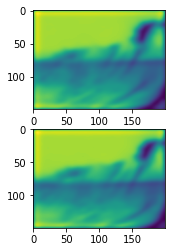

In [224]:
plt.subplot(2,1,1)
plt.imshow(BCmod)
plt.subplot(2,1,2)
plt.imshow(barycentre)

# Images duck and redcross

In [193]:
I1 = plt.imread('data/duck.png')
I2 = plt.imread('data/redcross.png')
I2 = I2[50:562,50:562,:]
m = I1[:,:,2:3]
h = I2[:,:,2:3]

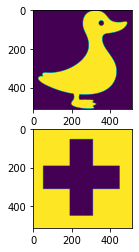

In [194]:
plt.subplot(2,1,1)
plt.imshow(m)
plt.subplot(2,1,2)
plt.imshow(h)

In [195]:
m = m/np.sum(m)
h = h/np.sum(h)

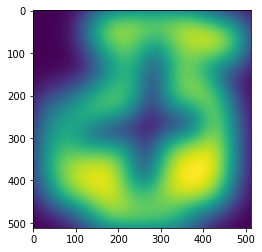

In [196]:
A = []
A.append(m[:,:,0])
A.append(h[:,:,0])
A = np.array(A)
barycenter = ot.bregman.convolutional_barycenter2d(A, 0.01, (0.5,0.5))
plt.imshow(barycenter)

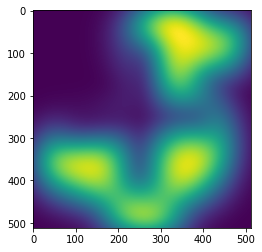

In [197]:
barycenter2 = convBarycenter(m, h, 0.01, 5, 0.5, 1)
BCmod = np.zeros((barycenter2.shape))
BCmod = barycenter2*(1/barycenter2.max())
plt.imshow(BCmod)

# Images couleurs avec calcul barycentre sur chaque bande spectrale

In [225]:
I1 = plt.imread('data/coucher.jpg')
I2 = plt.imread('data/ocean.jpg')
m = I1[100:250, 450:650, :]/255
h = I2[250:400,380:580,:]/255
b = m.shape[2]
nL = m.shape[0]
nC = m.shape[1]

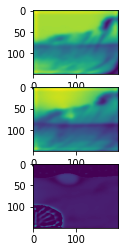

In [262]:
BAR1 = np.zeros((m.shape))
BAR2 = np.zeros((m.shape))
for i in range(3):
    m_s = m[:,:,i:i+1]
    h_s = h[:,:,i:i+1]
    m_s = m_s/np.sum(m_s)
    h_s = h_s/np.sum(h_s)
    A = []
    A.append(m_s[:,:,0])
    A.append(h_s[:,:,0])
    A = np.array(A)
    barycentre1 = convBarycenter(m_s, h_s, 0.001, 5, 0.5, 1)
    BCmod1 = np.zeros((barycentre1.shape))
    BCmod1 = barycentre1*(1/barycentre1.max())
    BAR1[:,:,i] = BCmod1[:,:,0]
    barycentre2 = ot.bregman.convolutional_barycenter2d(A, 0.001, (0.5,0.5))
    BCmod2 = np.zeros((barycentre2.shape))
    BCmod2 = barycentre2*(1/barycentre2.max())
    plt.subplot(3,1,i+1)
    plt.imshow(BCmod2)
    BAR2[:,:,i] = BCmod2

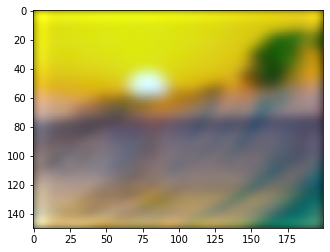

In [264]:
plt.imshow(BAR1)

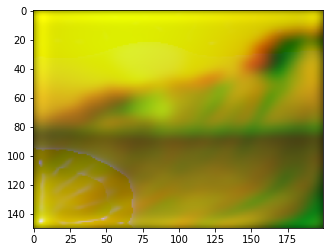

In [265]:
plt.imshow(BAR2)

# Barycentre image couleur

In [292]:
I1 = plt.imread('data/coucher.jpg')
I2 = plt.imread('data/ocean.jpg')
m = I1[100:250, 450:650, :]/255
h = I2[250:400,380:580,:]/255
b = m.shape[2]
nL = m.shape[0]
nC = m.shape[1]

In [293]:
def normalize(im):
    imNorm = np.zeros((im.shape))
    for i in range(im.shape[2]):
        imNorm[:,:,i] = im[:,:,i]/np.sum(im[:,:,i])
    return imNorm
        
m = normalize(m)
h = normalize(h)
barycentre = convBarycenter(m, h, 0.001, 5, 0.5, 10)

In [294]:
BCmod = np.zeros((barycentre.shape))
BCmod[:,:,0] = barycentre[:,:,0]*(1/barycentre[:,:,0].max())
BCmod[:,:,1] = barycentre[:,:,1]*(1/barycentre[:,:,1].max())
BCmod[:,:,2] = barycentre[:,:,2]*(1/barycentre[:,:,2].max())

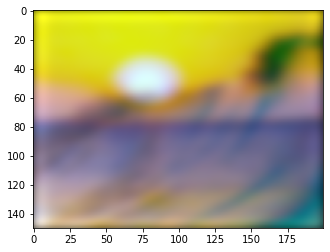

In [295]:
plt.imshow(BCmod)

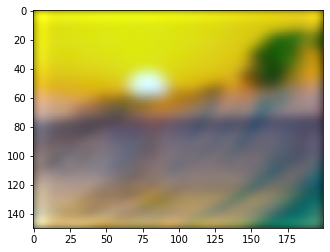

In [296]:
barycentre = convBarycenter(m, h, 0.001, 5, 0.5, 1)
BCmod = np.zeros((barycentre.shape))
BCmod[:,:,0] = barycentre[:,:,0]*(1/barycentre[:,:,0].max())
BCmod[:,:,1] = barycentre[:,:,1]*(1/barycentre[:,:,1].max())
BCmod[:,:,2] = barycentre[:,:,2]*(1/barycentre[:,:,2].max())
plt.imshow(BCmod)

#  POT with simple images

In [358]:
Im1 = np.zeros((100,100,3))
Im2 = np.zeros((100,100,3))
for i in range(100):
    for j in range(100):
        if (i>=20 and i<=40) and (j>=20 and j<=40):
            Im1[i,j,0] = 0.8
            Im1[i,j,1] = 0
            Im1[i,j,2] = 0
            
        if (i>=20 and i<=40) and (j>=60 and j<=80):
            Im2[i,j,0] = 0.8
            Im2[i,j,1] = 0
            Im2[i,j,2] = 0

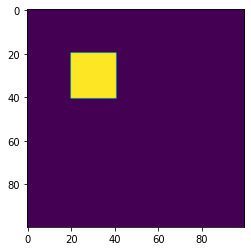

In [360]:
plt.imshow(Im1[:,:,0])

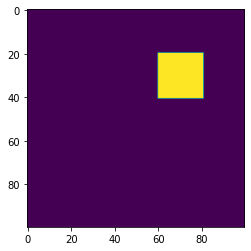

In [361]:
plt.imshow(Im2[:,:,0])

In [362]:
m = normalize(Im1[:,:,0:1])
h = normalize(Im2[:,:,0:1])

In [363]:
A = []
A.append(m[:,:,0])
A.append(h[:,:,0])
A = np.array(A)
barycenter = ot.bregman.convolutional_barycenter2d(A, 0.01, (0.5,0.5))

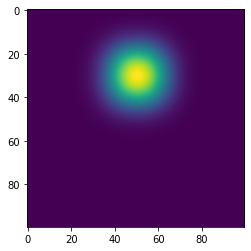

In [364]:
plt.imshow(barycenter)